In [1]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from miditime.miditime import MIDITime
import datetime
import julian as jl
from midiutil.MidiFile3 import MIDIFile
import pygame

pygame 1.9.4
Hello from the pygame community. https://www.pygame.org/contribute.html


But Hanson and other fire ecologists caution that the administration has it backwards: More logging can actually make wildfires burn hotter and faster. Instead, they say, it’s well-placed, smart management that will reduce the impacts to communities from wildfires—and unchecked logging is neither.

https://www.backpacker.com/news-and-events/why-we-cant-log-our-way-out-of-wildfires

In [2]:
'''
Combines the Julian date with the TOD that the event occurred and outputs a datetime
'''
def fix_datetime(jul, hour, minute, second):
    #validate input
    if (int(hour) < 0 or int(hour) > 24):
        print("Hour not between 0 and 24 inclusive")
        return
    if (int(minute) < 0 or int(minute) > 60):
        print("Minute not between 0 and 60 inclusive")
        return
    if (second < 0 or second > 60):
        print("Second not between 0 and 60 inclusive")
        return
    #Get Decimal for time of day.
    dec_time = ((int(hour)*60*60) + (int(minute)*60) + second) / 86400
    jul_str = str(jul)
    flt_jul = float(jul_str) + dec_time
    dt = jl.from_jd(round(flt_jul,2), fmt='jd')
    return dt.replace(microsecond=0)

I'm going to be doing some data sonification/visualization on wildfire data from 1992-2015 from the wildfire dataset found on Kaggle https://www.kaggle.com/rtatman/188-million-us-wildfires

https://www.nwcg.gov/

Data Sonification Inspiration:
<li> Outside Online episode (need to get reference)\
<li> https://www.revealnews.org/blog/turn-your-data-into-sound-using-our-new-miditime-library/

In [3]:
cnx = sqlite3.connect('/Users/JG/Documents/DataScience/WildFire/FPA_FOD_20170508.sqlite')

In [4]:
#All I need is the DISCOVERY_DATE, and FIRE_SIZE.
df_sonify = pd.read_sql_query("select DISCOVERY_DATE, DISCOVERY_TIME, FIRE_SIZE, LATITUDE, LONGITUDE FROM 'Fires' where STATE = 'MT' and FIRE_YEAR >= 2015 order by DISCOVERY_DATE asc LIMIT 20", cnx)
df_sonify.dropna()
df_sonify.head()

,DISCOVERY_DATE,DISCOVERY_TIME,FIRE_SIZE,LATITUDE,LONGITUDE
0,2457049.5,2030,0.3,45.4281,-108.5314
1,2457049.5,1600,0.7,48.2550,-109.7414
2,2457051.5,1537,0.3,45.6364,-106.6225
3,2457052.5,0853,0.1,48.0314,-108.6906
4,2457052.5,1400,2.0,45.3761,-108.0736


In [5]:
for index, row in df_sonify.iterrows():
    if (str(row['DISCOVERY_DATE']).lower() == 'none' or str(row['DISCOVERY_TIME']).lower() == 'none'):
        df_sonify.drop(index, inplace=True)
    else:
        df_sonify.loc[index, 'DISCOVERY_DATE'] = fix_datetime(row["DISCOVERY_DATE"], row["DISCOVERY_TIME"][0:2], row["DISCOVERY_TIME"][2:], 00)

In [6]:
df_sonify = df_sonify.drop(columns='DISCOVERY_TIME')

In [7]:
#Make sure DF is ordered by BEAT number:
df_sonify = df_sonify.sort_values(by=['DISCOVERY_DATE'])
df_sonify.head()

,DISCOVERY_DATE,FIRE_SIZE,LATITUDE,LONGITUDE
1,2015-01-27 16:04:47,0.7,48.2550,-109.7414
0,2015-01-27 20:24:00,0.3,45.4281,-108.5314
2,2015-01-29 15:35:59,0.3,45.6364,-106.6225
3,2015-01-30 08:52:48,0.1,48.0314,-108.6906
4,2015-01-30 13:55:12,2.0,45.3761,-108.0736


In [8]:
#Get min and max values of FIRE_SIZE for logarithmic scale
c = cnx.cursor()
c.execute("select MAX(FIRE_SIZE) FROM 'Fires' where STATE = 'MT' and FIRE_YEAR >= 2015")
max_fire = c.fetchone()[0]
c.execute("Select MIN(FIRE_SIZE) FROM 'Fires' where STATE = 'MT'and FIRE_YEAR >= 2015")
min_fire = c.fetchone()[0]


In [9]:
print(max_fire)
print(min_fire)

69435.0
0.01


In [10]:
# https://github.com/cirlabs/miditime
mymidi = MIDITime(120, 'myfile_rough.mid', 12, 1, 7, df_sonify.iloc[0]['DISCOVERY_DATE'])

In [11]:
def mag_to_pitch_tuned(magnitude, max_fire, min_fire):
    #Logarithmic scale, reverse order
    scale_pct = mymidi.log_scale_pct(min_fire, max_fire, magnitude, True,direction='log')

    # Pick a range of notes. This allows you to play in a key.
    c_major = ['C', 'D', 'E', 'F', 'G', 'A', 'B']

    #Find the note that matches your data point
    note = mymidi.scale_to_note_classic(scale_pct, c_major)

    #Translate that note to a MIDI pitch
    midi_pitch = mymidi.note_to_midi_pitch(note)

    return midi_pitch

In [12]:
for index, row in df_sonify.iterrows():
    df_sonify.loc[index, 'DAYS_SINCE_EPOCH'] = mymidi.days_since_epoch(row['DISCOVERY_DATE'])

In [13]:
for index, row in df_sonify.iterrows():
    df_sonify.loc[index, 'BEAT'] = mymidi.beat(row['DAYS_SINCE_EPOCH'])

In [14]:
for index, row in df_sonify.iterrows():
    df_sonify.loc[index, 'SCALED_FIRE_SIZE'] = mag_to_pitch_tuned(row['FIRE_SIZE'], max_fire, min_fire)

C6
F6
F6
B6
G5
B5
B6
F6
C6
F6
B6
F6
E4
D5
E6
F5
F6
B5
D6
B6


In [15]:
#reset indices
df_sonify = df_sonify.reset_index(drop=True)
df_sonify.head()

,DISCOVERY_DATE,FIRE_SIZE,LATITUDE,LONGITUDE,DAYS_SINCE_EPOCH,BEAT,SCALED_FIRE_SIZE
0,2015-01-27 16:04:47,0.7,48.2550,-109.7414,0.000000,0.00,72.0
1,2015-01-27 20:24:00,0.3,45.4281,-108.5314,0.180012,0.01,77.0
2,2015-01-29 15:35:59,0.3,45.6364,-106.6225,1.980000,0.13,77.0
3,2015-01-30 08:52:48,0.1,48.0314,-108.6906,2.700012,0.18,83.0
4,2015-01-30 13:55:12,2.0,45.3761,-108.0736,2.910012,0.19,67.0


In [16]:
start_time = df_sonify['BEAT'][0]

In [17]:
note_list = []

for index, row in df_sonify.iterrows():
    note_list.append([
        row['BEAT'] - start_time,
        int(row['SCALED_FIRE_SIZE']),
        100,  # velocity
        1  # duration, in beats
    ])

In [18]:
track    = 0
channel  = 0
time     = 0    # In beats
tempo    = mymidi.tempo   # In BPM

In [19]:
MyMIDI = MIDIFile(1)  # One track
MyMIDI.addTempo(track, time, tempo)

In [20]:
for n in note_list:
    MyMIDI.addNote(track, channel, n[1], n[0], n[3], n[2])

In [21]:
with open(mymidi.outfile, "wb") as output_file:
    MyMIDI.writeFile(output_file)

In [22]:
df_mapping = df_sonify

In [23]:
df_mapping.head()

,DISCOVERY_DATE,FIRE_SIZE,LATITUDE,LONGITUDE,DAYS_SINCE_EPOCH,BEAT,SCALED_FIRE_SIZE
0,2015-01-27 16:04:47,0.7,48.2550,-109.7414,0.000000,0.00,72.0
1,2015-01-27 20:24:00,0.3,45.4281,-108.5314,0.180012,0.01,77.0
2,2015-01-29 15:35:59,0.3,45.6364,-106.6225,1.980000,0.13,77.0
3,2015-01-30 08:52:48,0.1,48.0314,-108.6906,2.700012,0.18,83.0
4,2015-01-30 13:55:12,2.0,45.3761,-108.0736,2.910012,0.19,67.0


In [24]:
from mido import MidiFile

mid = MidiFile(mymidi.outfile)
mid.length
#for i, track in enumerate(mid.tracks):
#    print('Track {}: {}'.format(i, track.name))
#    for msg in track:
#        print(msg)   

1.75

In [25]:
mid.ticks_per_beat

960

In [26]:
#create a new column with number of ticks:
for index, row in df_mapping.iterrows():
    df_mapping.loc[index, 'TICKS'] = row['BEAT'] * mid.ticks_per_beat

In [27]:
#Determine how many milliseconds per tick: 60000 / (BPM * PPQ)
millis_per_tick = 60000.0 / (120 * mid.ticks_per_beat)
print(millis_per_tick)

0.5208333333333334


In [28]:
#create a new column with time elapsed in milliseconds
for index, row in df_mapping.iterrows():
    df_mapping.loc[index, 'MILLIS'] = row['TICKS'] * millis_per_tick

In [29]:
df_mapping = df_mapping.sort_values(by=['BEAT'])
df_mapping.head()

,DISCOVERY_DATE,FIRE_SIZE,LATITUDE,LONGITUDE,DAYS_SINCE_EPOCH,BEAT,SCALED_FIRE_SIZE,TICKS,MILLIS
0,2015-01-27 16:04:47,0.7,48.2550,-109.7414,0.000000,0.00,72.0,0.0,0.0
1,2015-01-27 20:24:00,0.3,45.4281,-108.5314,0.180012,0.01,77.0,9.6,5.0
2,2015-01-29 15:35:59,0.3,45.6364,-106.6225,1.980000,0.13,77.0,124.8,65.0
3,2015-01-30 08:52:48,0.1,48.0314,-108.6906,2.700012,0.18,83.0,172.8,90.0
4,2015-01-30 13:55:12,2.0,45.3761,-108.0736,2.910012,0.19,67.0,182.4,95.0


In [ ]:
#Create an index list for frames for the matplotlib animation
frames_list = list(df_mapping['MILLIS'])

In [ ]:
#convert from floats to ints:
frames_list = [int(i) for i in frames_list]

In [ ]:
frames_list_test_deltas = [x - frames_list[i - 1] for i, x in enumerate(frames_list)][1:]
print(frames_list_test_deltas)

In [ ]:
#create index list for frames, i.e. how many cycles each frame will be displayed
#https://stackoverflow.com/questions/49796314/animate-with-variable-time
frames_t = []
for i, item in enumerate(frames_list_test_deltas):
    frames_t.extend([i]*item)


#Note: test the first 20 and figure out why it is incrementing so much in animate vs the example.....

In [ ]:
'''
***Each year has a different color plot point, perhaps color is defined in dataframe and is assigned as part of data cleanup.??.??.

***Need to be sure not to get index out of bounds exception, so only increment if index <= last record

Iterate thru midi file with pygame
    Q up next record in dataframe with beat Number:
    while iterating thru midi file 
        if record beat = loop beat generate new image with plot point and increment record index to next record
        if record beat != loop beat repeat existing image with existing plot point.
'''


%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.transforms import offset_copy
import cartopy.crs as ccrs
import cartopy.io.img_tiles as cimgt
import cartopy.feature as cfeature
from matplotlib.animation import FuncAnimation



map_terrain = cimgt.Stamen('terrain-background')
fig = plt.figure(figsize=(19.2,10.8))
ax = plt.axes(projection=map_terrain.crs)
ax.set_extent([-116.5, -103, 44, 49.5]) #Montana boundary box
ax.add_image(map_terrain,8,zorder=0)
ax.add_feature(cfeature.STATES, zorder=1)

def update(frame_number):
    image = ax.plot(df_mapping['LONGITUDE'][frame_number], df_mapping['LATITUDE'][frame_number], marker='o', color='r', 
             markersize=df_mapping['SCALED_FIRE_SIZE'][frame_number]/10, alpha=0.7, transform=map_terrain.crs.as_geodetic(), zorder=2)
    
    return image,

anim = FuncAnimation(fig, update, interval=1, frames=frames_t)#,save_count=200)#len(df_mapping.index))

In [ ]:
#HTML(anim.to_html5_video()) #creating a frame every millisecond, so we need 1000 frames per second times 12 frames per second for a 120bpm song. = 12000 ? this is a guess...
anim.save('wildfire_mov.mpeg', 'ffmpeg', fps=15)

In [31]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.transforms import offset_copy
import cartopy.crs as ccrs
import cartopy.io.img_tiles as cimgt
import cartopy.feature as cfeature
from matplotlib.animation import FuncAnimation

In [32]:
frames_per_second = 30
millis_per_frame = 1000 / frames_per_second
print (millis_per_frame)

33.333333333333336


In [33]:
beats_per_minute = 120
beats_per_second = beats_per_minute/ 60
frames_per_beat = frames_per_second / beats_per_second
print (beats_per_second)
print (frames_per_beat)

2.0
15.0


In [34]:
#We're going to focus on increasing the milliseconds as our loop control for creating frames
#We already have when each point occurs in the midi file at specified millisecond.
#We need to check each loop which occurs every 33.33333333336 milliseconds and see if records exist in our specified plot range.



In [90]:
milli_counter = 0.0
milli_span = 1000.0
file_idx = 0

In [91]:
#Modified from Matt Leonards Example: https://medium.com/udacity/creating-map-animations-with-python-97e24040f17b  
def make_grads_map(data, ax=None):
    
    if ax is None:
        fig = plt.figure(figsize=(19.2,10.8))
        ax = plt.axes(projection=map_terrain.crs)
    
    map_terrain = cimgt.Stamen('terrain-background')
    ax.set_extent([-116.5, -103, 44, 49.5]) #Montana boundary box
    ax.add_image(map_terrain,8,zorder=0)
    ax.add_feature(cfeature.STATES, zorder=1)
    
    if (milli_counter - milli_span <= 0):
        milli_min = 0
    else:
        milli_min = milli_counter - milli_span
    
    plot_df = data[data['MILLIS'].between(milli_min, milli_counter, inclusive=True)]

    for index, row in plot_df.iterrows():
        ax.plot(row['LONGITUDE'], row['LATITUDE'], marker='o', color='r', 
             markersize=row['SCALED_FIRE_SIZE']/10, alpha=0.7, transform=map_terrain.crs.as_geodetic(), zorder=2)
    return ax

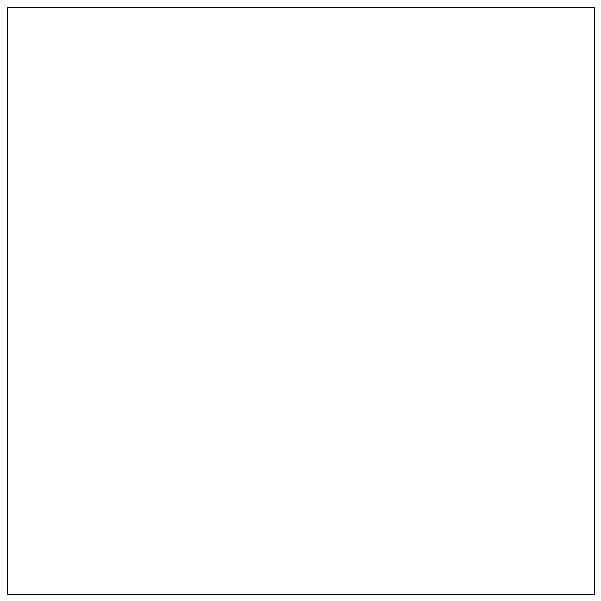

In [92]:
#create figure and axes
map_terrain = cimgt.Stamen('terrain-background')
fig = plt.figure(figsize=(19.2,10.8))
ax = plt.axes(projection=map_terrain.crs)

# Generate an image for each day between start_date and end_date
while milli_counter <= df_mapping['MILLIS'].max():
    ax = make_grads_map(df_mapping, ax=ax)
    #fig.tight_layout(pad=-0.5)
    fig.savefig(f"Frames/frame_{file_idx}.png", dpi=100,     
                frameon=True, facecolor='black')
    ax.clear()
    file_idx += 1
    milli_counter += millis_per_frame
    